In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)


tensorflow: 2.16.1


C:\Users\AndUser\AppData\Roaming\Python\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Підготовка даних

In [6]:
EXPECTED_SAMPLE_RATE = 16000
# uploaded_file_name = 'data/VocalSet1-2/data_by_technique/straight/arpeggios_straight_a.wav'
# userfile = 'data/VocalSet1-2/data_by_technique/straight/arpeggios_straight_a.wav'

uploaded_file_name = 'f7_scales_c_slow_forte_o.wav'
userfile =           'f7_scales_c_slow_forte_o.wav'
# uploaded_file_name = 'feast-on-me-feat-alicatt.wav'
# userfile = 'feast-on-me-feat-alicatt.wav'
def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [7]:
converted_audio_file = convert_audio_for_model(uploaded_file_name)

FileNotFoundError: [Errno 2] No such file or directory: 'f7_scales_c_slow_forte_o.wav'

In [4]:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')
fs = sample_rate
hop_length = 512 
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 11.38s
Size of the input: 182134


In [8]:

_ = plt.plot(audio_samples)

NameError: name 'audio_samples' is not defined

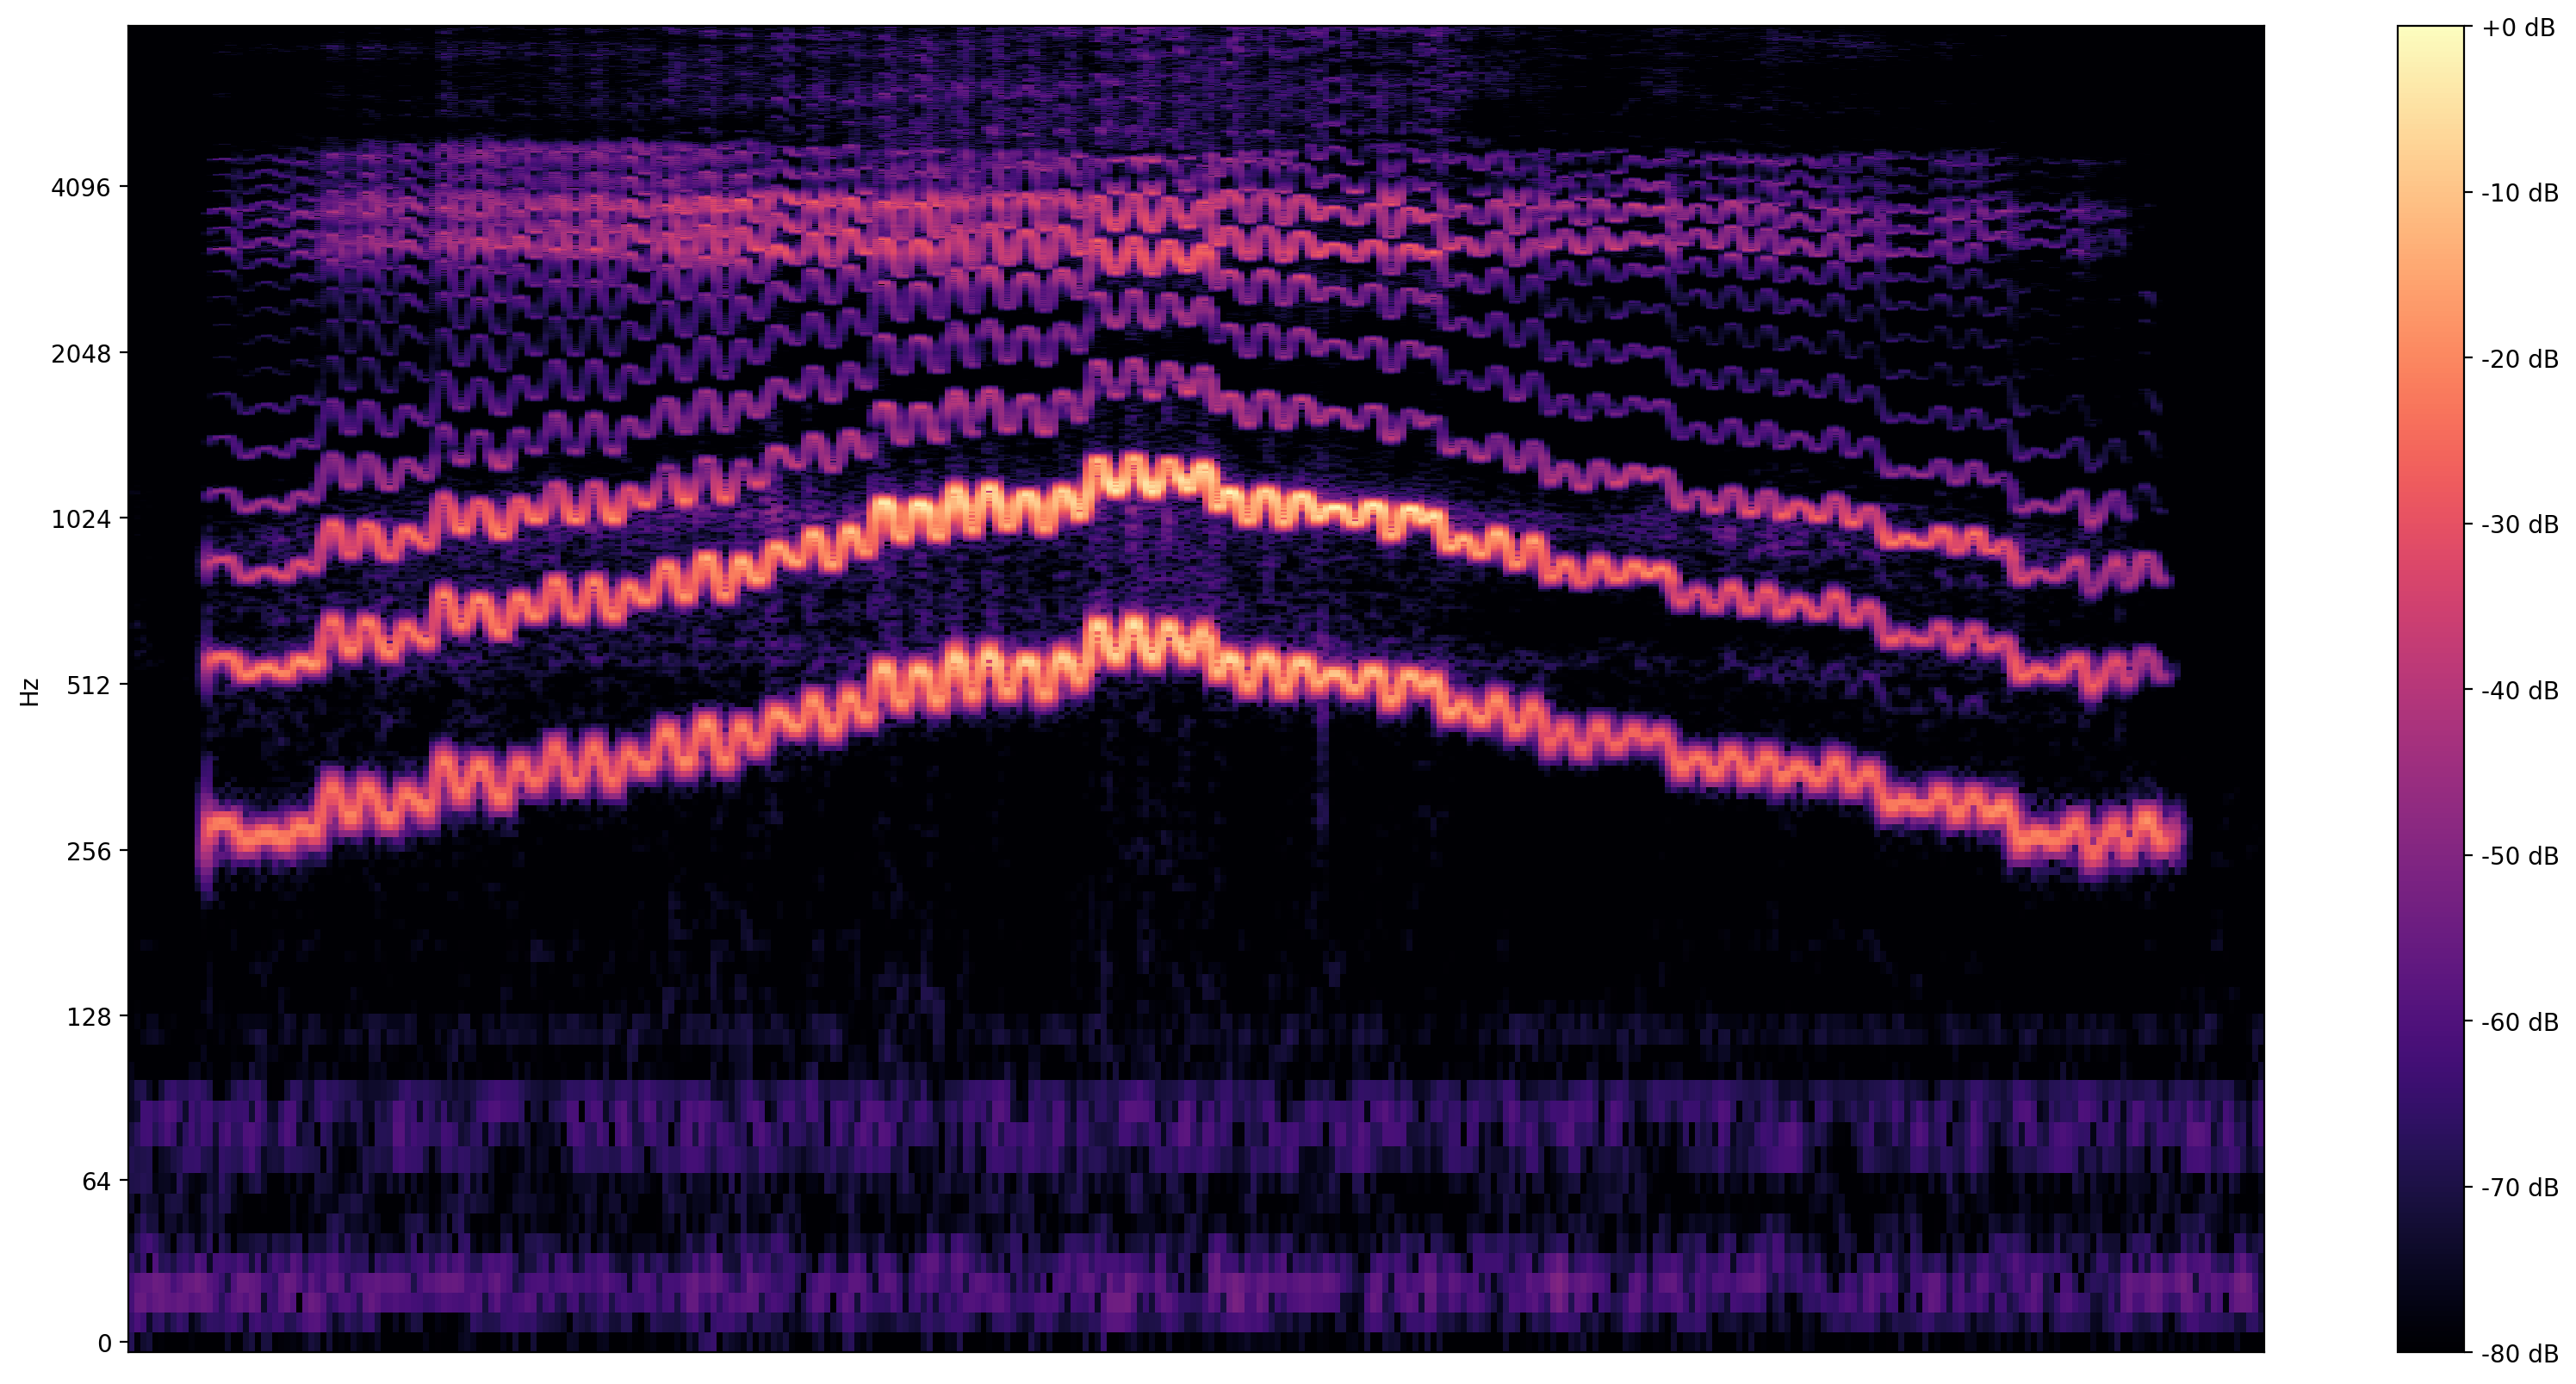

In [6]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


In [7]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

In [8]:
model = hub.load("https://tfhub.dev/google/spice/2")

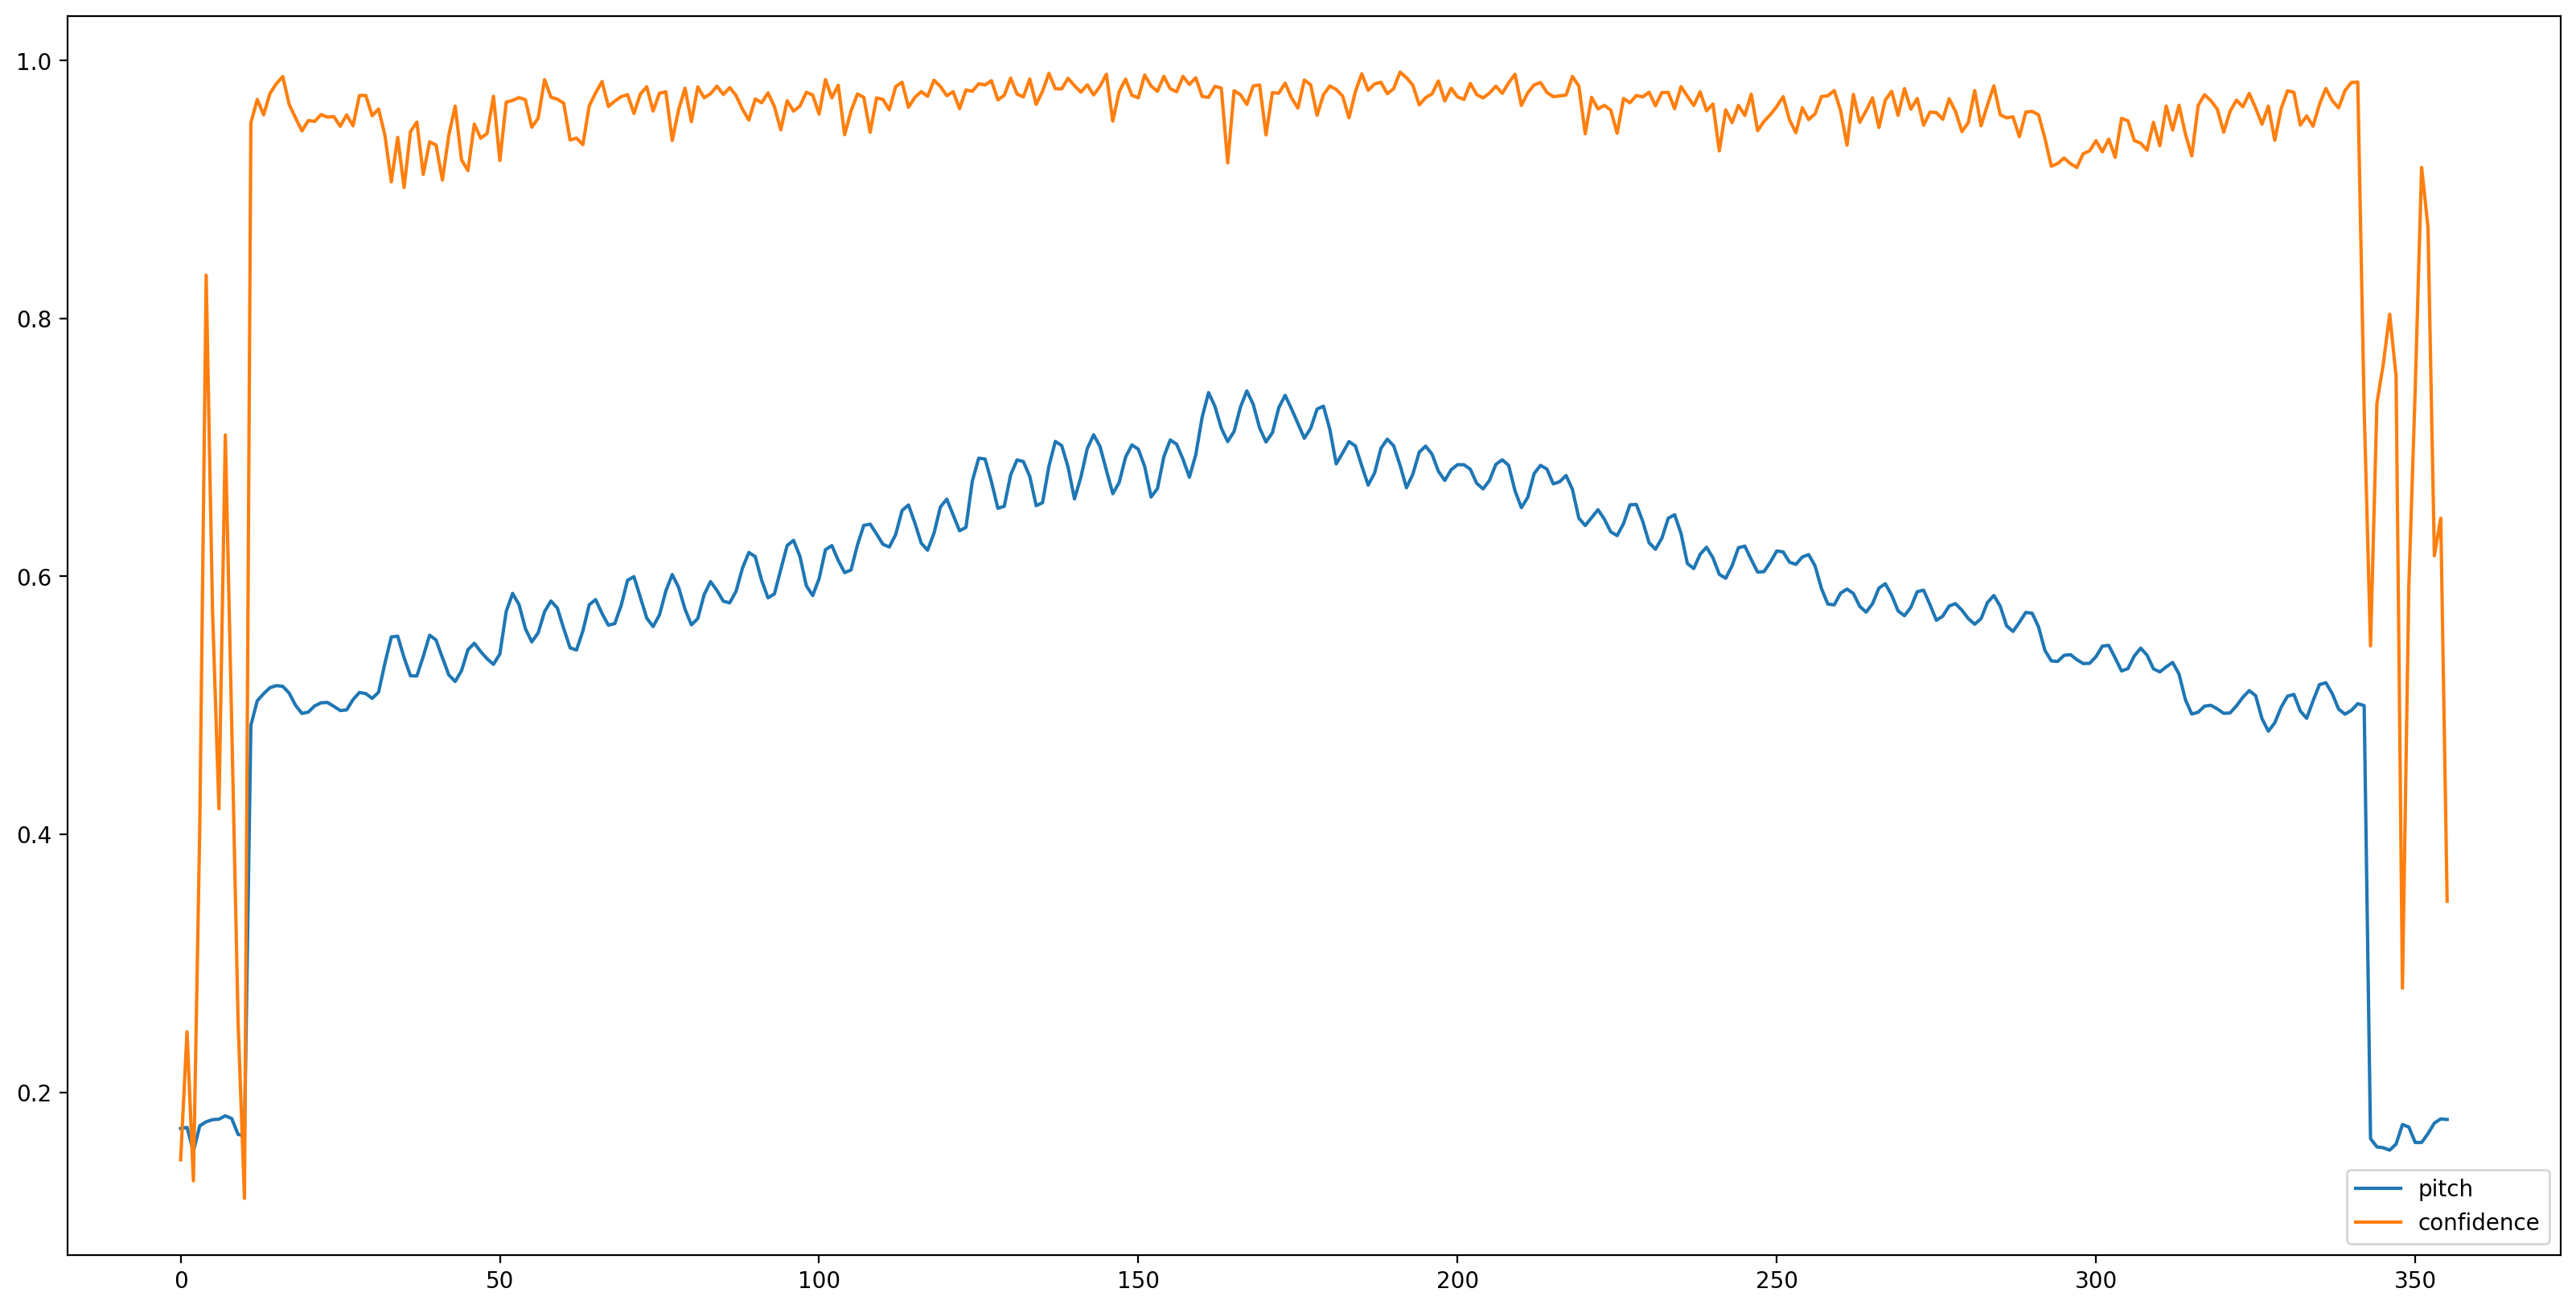

In [9]:
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

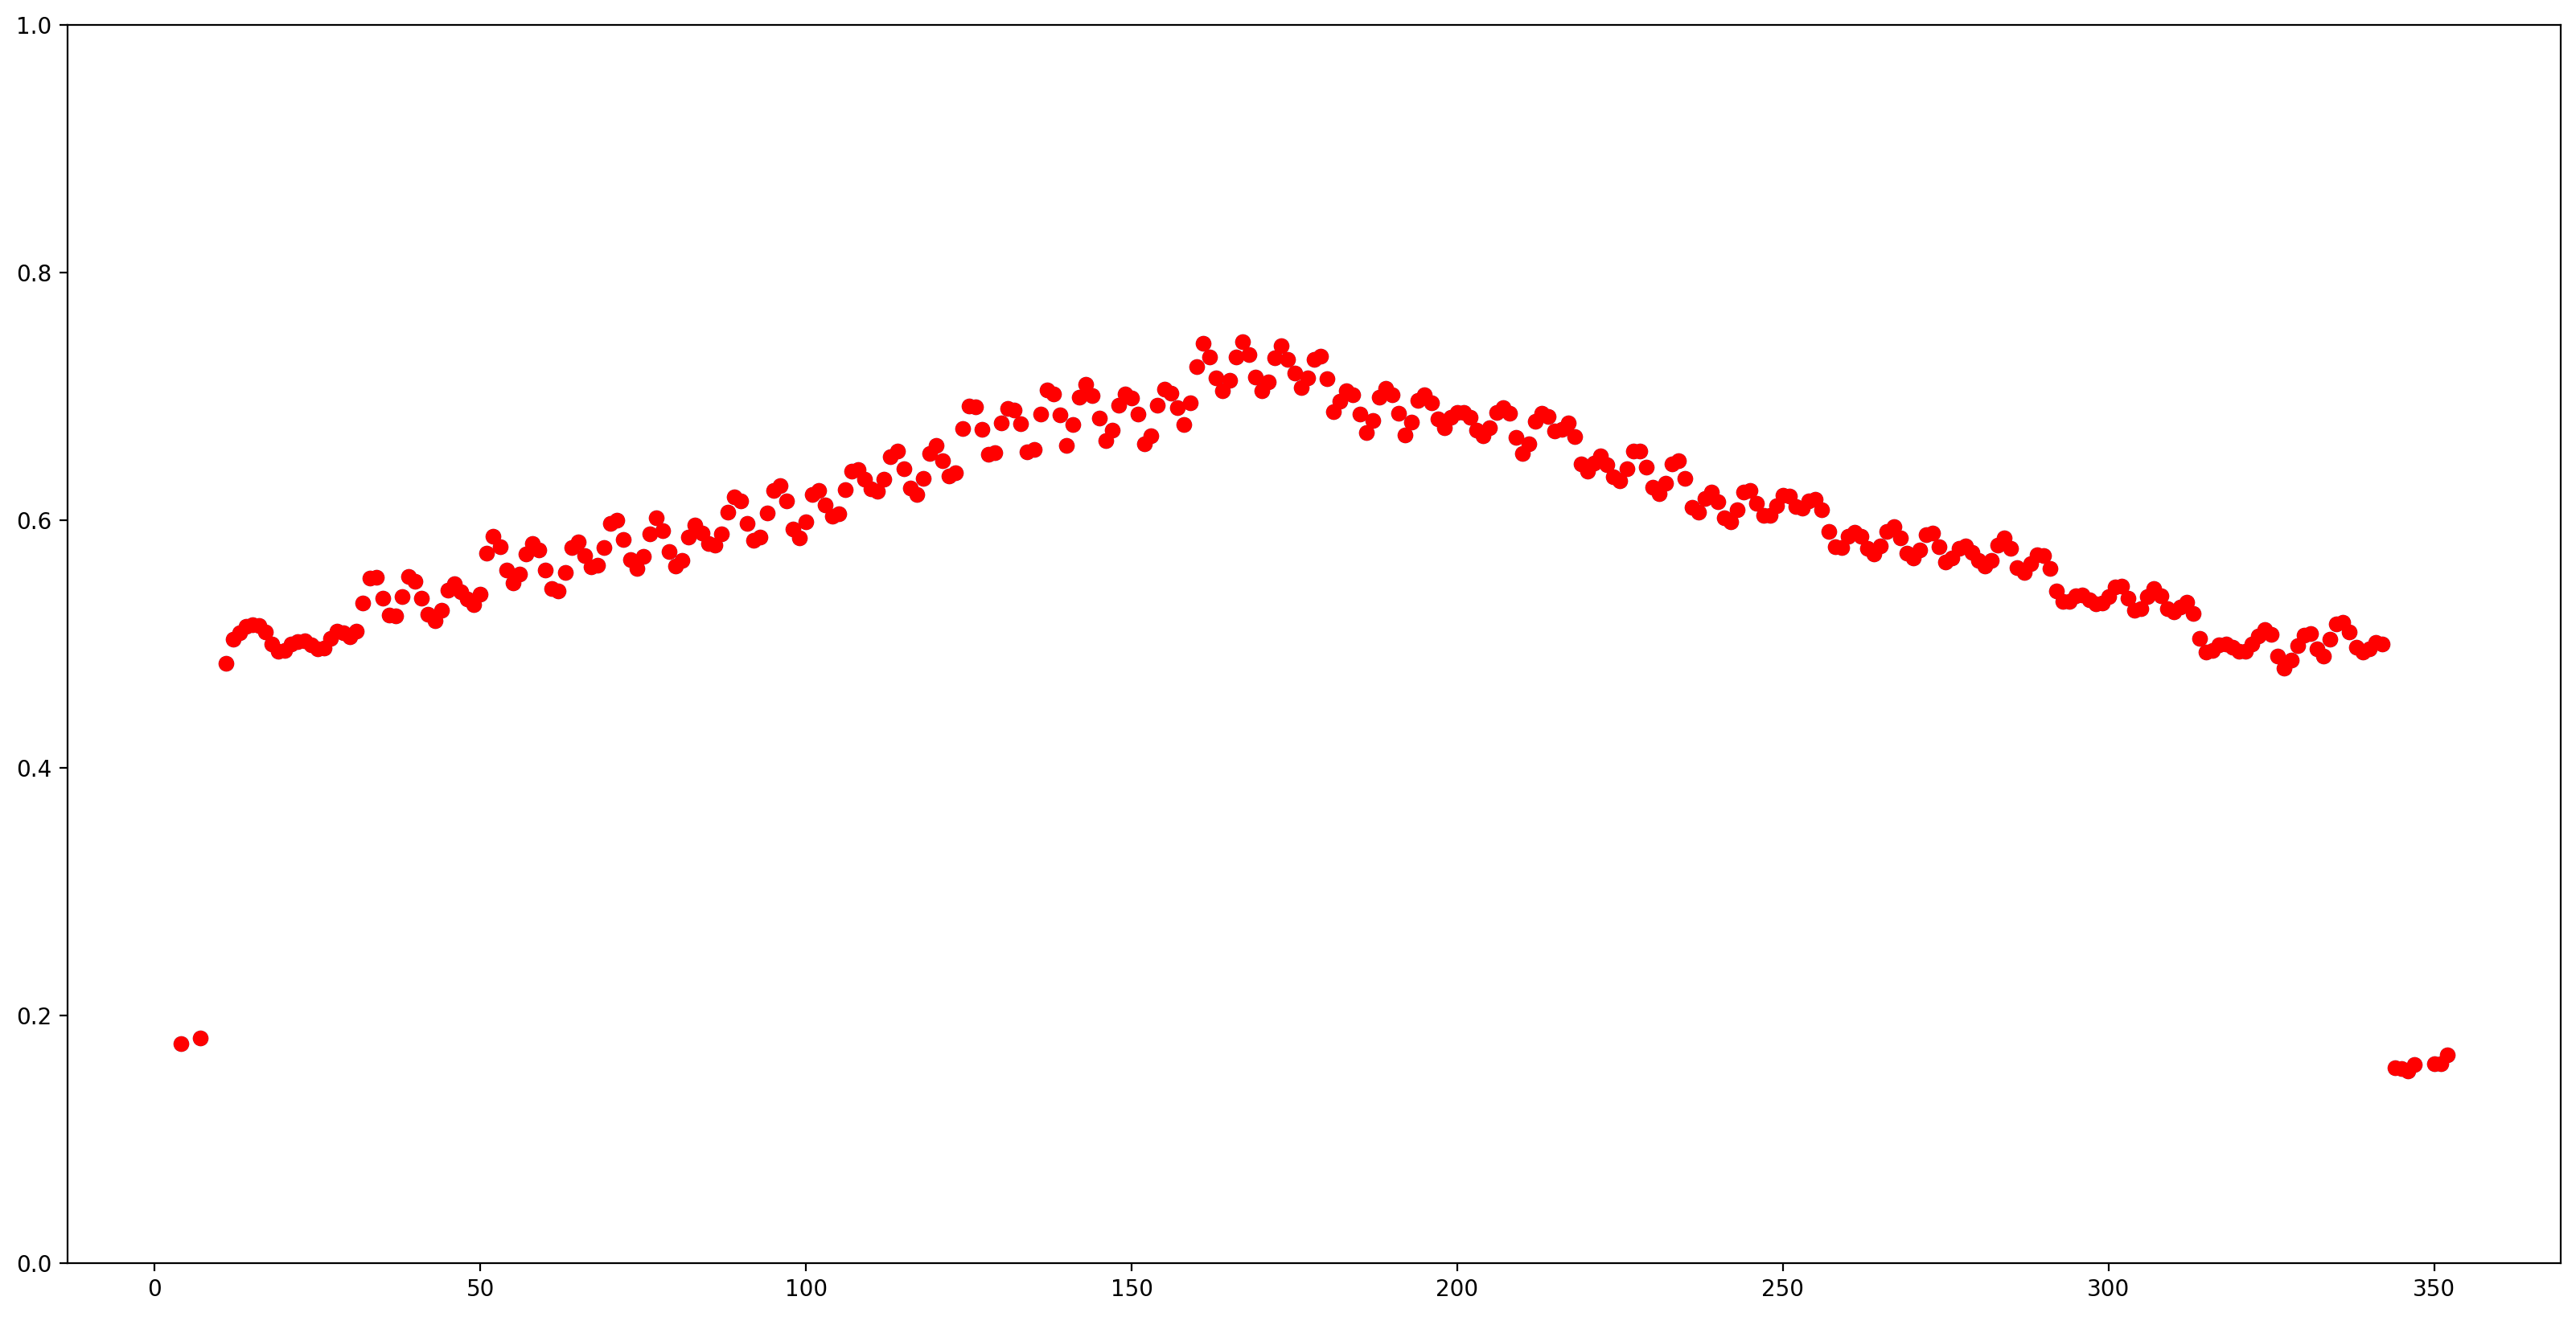

In [10]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.7  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
 
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

In [11]:
def output2hz(pitch_output):
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

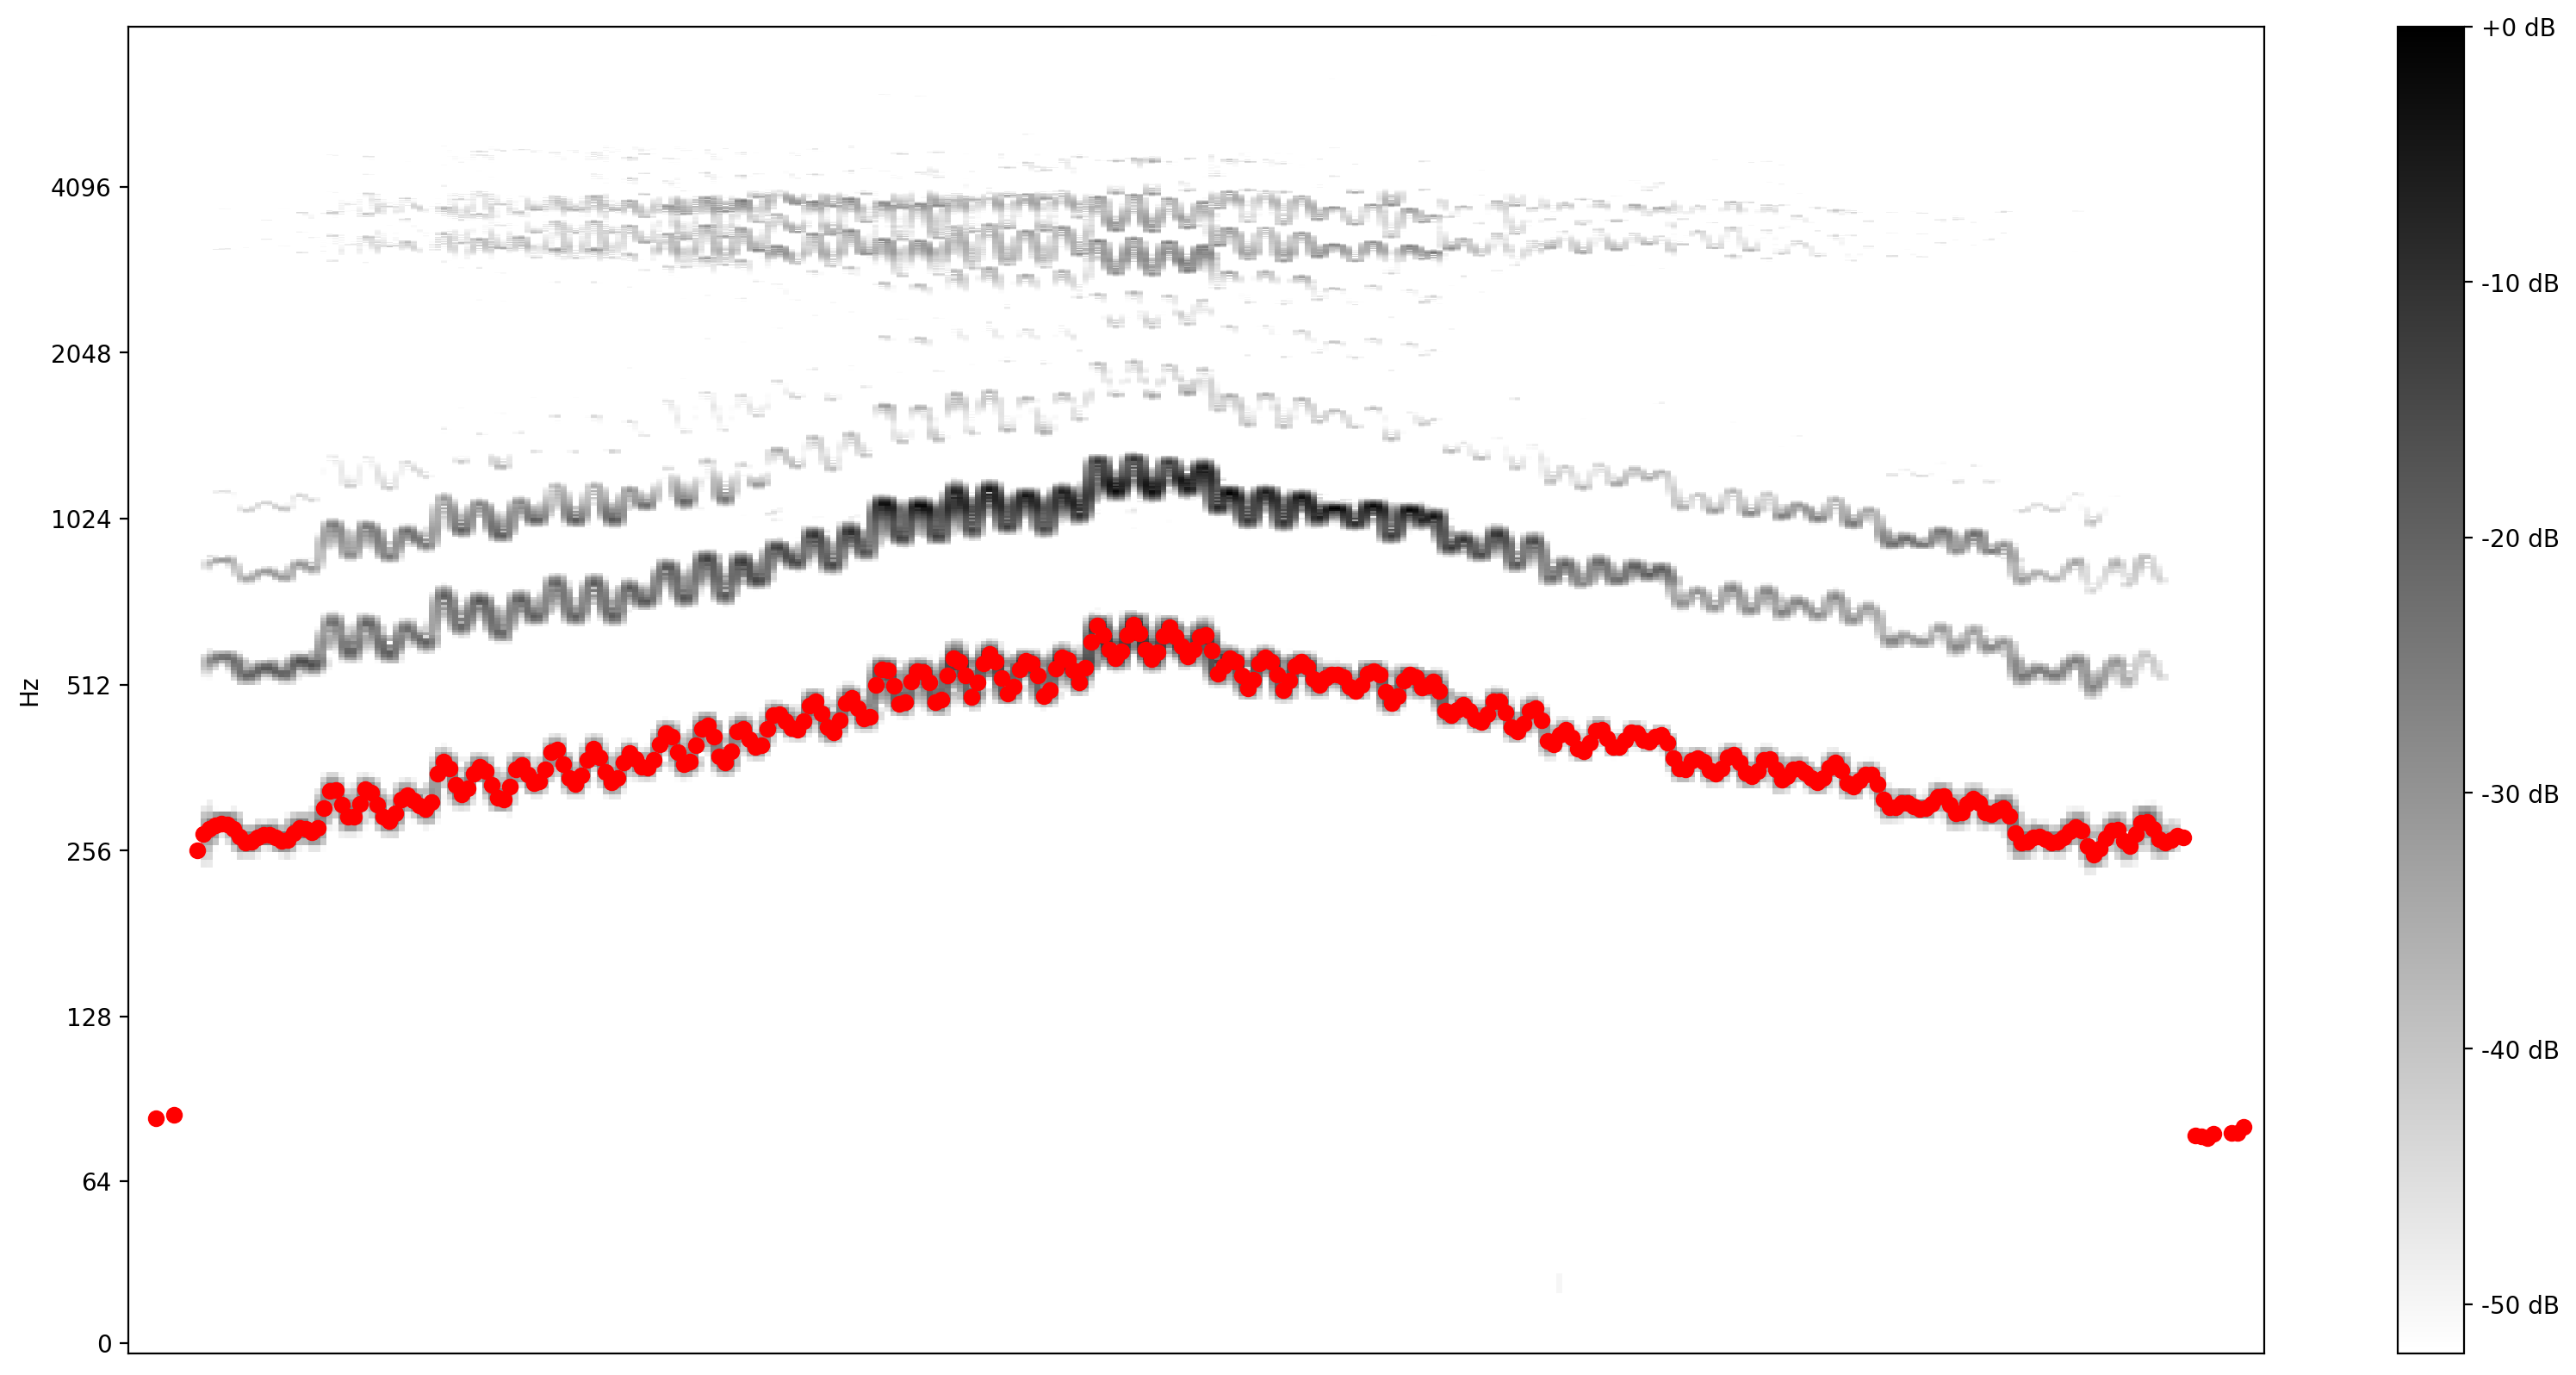

In [12]:
plot_stft(audio_samples / MAX_ABS_INT16 , 
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

In [13]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.7 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

In [14]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  if freq == 0:
    return None
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h

offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


offsets:  [0.23635140330846482, -0.4696205083901219, -0.38149223520104414, -0.1751046417528883, 0.17225895778591394, 0.4669702924912684, -0.4337663166100185, -0.4682575724894207, 0.2001226295655485, -0.3989256377393531, 0.20559593067820714, 0.27138682649786006, -0.42565589113776525, -0.2738229392344209, -0.25891369445865564, -0.4462848575288447, 0.34836341516430736, 0.3785559515779724, -0.12033967001978851, 0.23097115771229682, 0.17604453758652028, -0.05938694818561174, 0.2428353978818194, -0.3316663716608801, -0.053350882368732755, -0.015134194927853173, -0.06816445453708297, 0.04796468989308522, 0.03739363686497654, -0.003978764849350114, 0.032217506331754464, -0.2027064786726669, -0.06585626586024773, 0.09410214857514632, -0.23292758687083648, 0.3020571668570824, 0.3226487292473976, -0.36160308940951325, 0.23008810774738464, -0.12253094418589683, -0.39295742734019257, 0.11147953943665811, 0.19903319732601688, 0.07340814964230447, -0.4700725428635337, 0.3537775112813222, -0.295462581

In [15]:
def quantize_predictions(group, ideal_offset):
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  if zero_values_count > 0.8 * len(group):
    return 0.51 * len(non_zero_values), "Rest"
  else:
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])

    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:      
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

In [16]:
sc = music21.stream.Score()
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:   
    d = 'quarter'
    if snote == 'Rest':      
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  171.42857142857142


In [17]:
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [18]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


In [19]:
! "C:\Program Files\MuseScore 4\bin\MuseScore4.exe" converted_audio_file.mid